In [3]:
full = pd.read_csv('data/runs/full.csv').drop('Unnamed: 0', axis=1)
clean = full[full['Quality']>-0.95]
clean['started'] = pd.to_datetime(clean['started'])
clean = clean[clean['started'] > pd.to_datetime('2020-04-15 18:00:00')]
full['started'] = pd.to_datetime(full['started'])
full = full[full['started'] > pd.to_datetime('2020-04-15 18:00:00')]

/rwthfs/rz/cluster/home/kz035322/Thesis/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


# ANOVA

Here we train an ANOVA model on the configurations of the pipeline and their respective drug-agnostic $ r^2 $ to determine which factors lead to a bigger improvement in performance

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

In [41]:
clean = pd.read_csv('data/runs/clean.csv')

In [42]:
clean.shape

(119804, 77)

In [43]:
clean[['Drug', 'r2_score']].groupby('Drug').describe().sort_values(('r2_score', 'count'), ascending=False).head()

r2_score                                                    \
               count      mean       std       min       25%       50%   
Drug                                                                     
Selumetinib   4512.0  0.189548  0.177463 -0.586784  0.003512  0.215650   
Nutlin-3      4480.0  0.042574  0.222276 -1.956753 -0.029524  0.013063   
Paclitaxel    4479.0  0.114114  0.157428 -0.866935 -0.003286  0.121838   
Saracatinib   4452.0  0.089953  0.155960 -1.412134 -0.006891  0.083961   
TAE684        4451.0  0.054032  0.166655 -0.774732 -0.022764  0.016381   

                                 
                  75%       max  
Drug                             
Selumetinib  0.337072  0.598656  
Nutlin-3     0.129311  0.738862  
Paclitaxel   0.223766  0.479926  
Saracatinib  0.181256  0.586263  
TAE684       0.126441  0.693535

In [44]:
clean.columns

Index(['C', 'Drug', 'algorithm', 'alpha', 'bootstrap', 'cache_size', 'coef0',
       'copy_X', 'criterion', 'degree', 'epsilon', 'fit_intercept', 'gamma',
       'kernel', 'l1_ratio', 'leaf_size', 'max_depth', 'max_features',
       'max_iter', 'max_leaf_nodes', 'mean_absolute_error',
       'mean_squared_error', 'median_absolute_error', 'metric',
       'metric_params', 'min_impurity_decrease', 'min_impurity_split',
       'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf',
       'n_estimators', 'n_jobs', 'n_neighbors', 'normalize', 'oob_score', 'p',
       'positive', 'precompute', 'presort', 'r2_score', 'random_state', 'run',
       'selection', 'shrinking', 'splitter', 'tol', 'verbose', 'warm_start',
       'weights', 'operation', 'started', 'time', 'status', 'label', 'ajive',
       'ccle', 'ctrp', 'cutoff', 'drugs', 'feda', 'fs', 'gdsc', 'metric_drug',
       'model', 'n', 'norm', 'test', 'threshold', 'step', 'r_2_mean',
       'r_2_std', 'seconds', 'datasets', 

# ANOVA

We start by determining the factors and interaction factors using the patsy formula api

In [59]:
import patsy
import statsmodels.api as sm
f = 'r2 ~catn +Quality + fs:model + model +catn:model+ +norm:model+da:model+da+ctrp + gdsc + norm+C(datasets)+metric_drug'
y, X = patsy.dmatrices(f,clean.drop('C', axis=1), return_type='dataframe')

In [60]:
#X.columns

We drop factors that either don't exist on our model aand those that would cause multicolinearity

In [61]:
X = X.drop(['fs[T.f_regression]:model[DecisionTreeRegressor]', 'fs[T.ElasticNet]:model[ElasticNet]', 'fs[T.RandomForestRegressor]:model[RandomForestRegressor]'], axis=1)

We turn the results of the OLS from a `SimpleTable` into a `DataFrame`

In [62]:
mod = sm.OLS(y, X).fit()
results = pd.DataFrame(mod.summary(alpha=0.01).tables[1].data).set_index(0)
results = results.rename(columns=results.iloc[0])[1:]

In [63]:
results['[0.005'] = pd.to_numeric(results['[0.005'])
results['0.995]'] = pd.to_numeric(results['0.995]'])

We plot the factors for which 0 is not within the 99% confidence interval

In [64]:
results[results['[0.005']*results['0.995]'] > 0].sort_values('coef').head()

,coef,std err,t,P>|t|,[0.005,0.995]
0,,,,,,
C(datasets)[T.2],0.0165,0.002,7.532,0.000,0.011,0.022
da[T.none],0.0173,0.005,3.775,0.000,0.005,0.029
fs[T.Lasso]:model[RandomForestRegressor],0.0180,0.006,2.833,0.005,0.002,0.034
catn[T.mid],0.0199,0.005,4.014,0.000,0.007,0.033
fs[T.ElasticNet]:model[SVR],0.0217,0.007,2.955,0.003,0.003,0.041


In [65]:
results.shape

(83, 6)

We see 42 interaction factors are not significant (0 is within their 99% confidence interval)

In [66]:
results[results['[0.005']*results['0.995]'] > 0].sort_values('coef').shape

(36, 6)

We drop non-significant factors

In [67]:
drop = list(results[results['[0.005']*results['0.995]'] < 0].index)
drop = [i for i in drop if ':' in i]
X = X.drop(drop, axis=1)

Then retrain the OLS model

In [68]:
mod = sm.OLS(y, X).fit()
results = pd.DataFrame(mod.summary(alpha=0.01).tables[1].data).set_index(0)
results = results.rename(columns=results.iloc[0])[1:]
results['[0.005'] = pd.to_numeric(results['[0.005'])
results['0.995]'] = pd.to_numeric(results['0.995]'])
results['coef'] = pd.to_numeric(results['coef'])

In [69]:
anova = results[results['[0.005']*results['0.995]'] > 0]
anova = anova.sort_values('coef').reset_index().rename(columns={0:'factor'})

In [70]:
anova

,factor,coef,std err,t,P>|t|,[0.005,0.995]
0,Intercept,-0.1704,0.005,-37.700,0.000,-0.182,-0.159
1,da[T.feda],-0.0872,0.004,-20.375,0.000,-0.098,-0.076
2,norm[T.StandardScaler]:model[T.SVR],-0.0850,0.011,-7.889,0.000,-0.113,-0.057
3,norm[T.StandardScaler]:model[T.RandomForestReg...,-0.0824,0.010,-8.569,0.000,-0.107,-0.058
4,norm[T.StandardScaler]:model[T.KNeighborsRegre...,-0.0814,0.012,-6.538,0.000,-0.113,-0.049
5,norm[T.StandardScaler]:model[T.ElasticNet],-0.0785,0.008,-9.585,0.000,-0.100,-0.057
6,da[T.feda]:model[T.SVR],-0.0531,0.006,-8.346,0.000,-0.069,-0.037
7,da[T.feda]:model[T.KNeighborsRegressor],-0.0483,0.008,-6.006,0.000,-0.069,-0.028
8,norm[T.None]:model[T.RandomForestRegressor],-0.0431,0.006,-7.395,0.000,-0.058,-0.028
9,catn[T.low]:model[T.KNeighborsRegressor],-0.0341,0.007,-4.703,0.000,-0.053,-0.015


In [71]:
anova[(anova['coef']>0.03)|(anova['coef']<-0.03)]

,factor,coef,std err,t,P>|t|,[0.005,0.995]
0,Intercept,-0.1704,0.005,-37.700,0.000,-0.182,-0.159
1,da[T.feda],-0.0872,0.004,-20.375,0.000,-0.098,-0.076
2,norm[T.StandardScaler]:model[T.SVR],-0.0850,0.011,-7.889,0.000,-0.113,-0.057
3,norm[T.StandardScaler]:model[T.RandomForestReg...,-0.0824,0.010,-8.569,0.000,-0.107,-0.058
4,norm[T.StandardScaler]:model[T.KNeighborsRegre...,-0.0814,0.012,-6.538,0.000,-0.113,-0.049
5,norm[T.StandardScaler]:model[T.ElasticNet],-0.0785,0.008,-9.585,0.000,-0.100,-0.057
6,da[T.feda]:model[T.SVR],-0.0531,0.006,-8.346,0.000,-0.069,-0.037
7,da[T.feda]:model[T.KNeighborsRegressor],-0.0483,0.008,-6.006,0.000,-0.069,-0.028
8,norm[T.None]:model[T.RandomForestRegressor],-0.0431,0.006,-7.395,0.000,-0.058,-0.028
9,catn[T.low]:model[T.KNeighborsRegressor],-0.0341,0.007,-4.703,0.000,-0.053,-0.015


In [134]:
anova.shape

(38, 7)

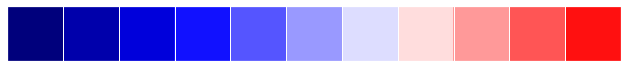

In [72]:
sns.palplot(sns.color_palette("seismic", n_colors=14)[:-3])

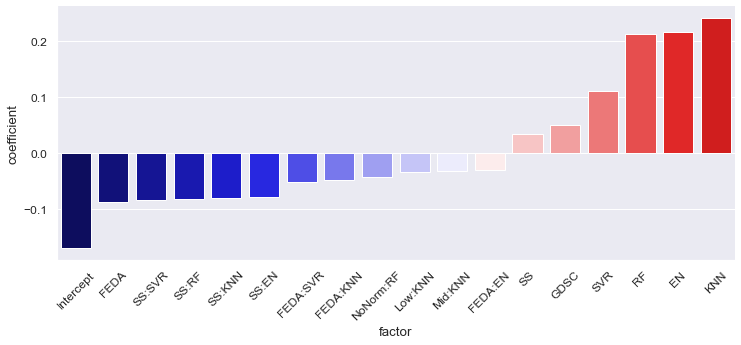

In [136]:
sns.set(font_scale=1.1)
g = sns.catplot(x='factor', y='coef', data=anova[(anova['coef']>0.03)|(anova['coef']<-0.03)],height=5, kind='bar', palette=sns.color_palette("seismic", n_colors=22)[:-4], aspect=2.1)
#labels = ['Intercept', 'FEDA','SS:SVR', 'SS:RF','SS:KNN','SS:EN', 'FEDA:SVR', 'FEDA:KNN', 'NoNorm:RF', 'Low:KNN', 'Mid:KNN', 'FEDA:EN', 'VLow:KNN','FEDA:RF', 'NoNorm:KNN', 'NoDA:KNN', 'VLow:EN','RF:SVR', 'CTRP', 'MI:RF', 'MinMax:SVR', 'MI:SVR', 'F:RF', 'NoNorm','SS', 'GDSC', 'SVR', 'RF', 'EN', 'KNN']
labels = ['Intercept', 'FEDA','SS:SVR', 'SS:RF','SS:KNN','SS:EN', 'FEDA:SVR', 'FEDA:KNN', 'NoNorm:RF', 'Low:KNN', 'Mid:KNN', 'FEDA:EN', 'SS', 'GDSC', 'SVR', 'RF', 'EN', 'KNN']


g.set_xticklabels(labels, rotation=45)
g.set(ylabel='coefficient')
plt.tight_layout()
#plt.savefig('anova2.png')

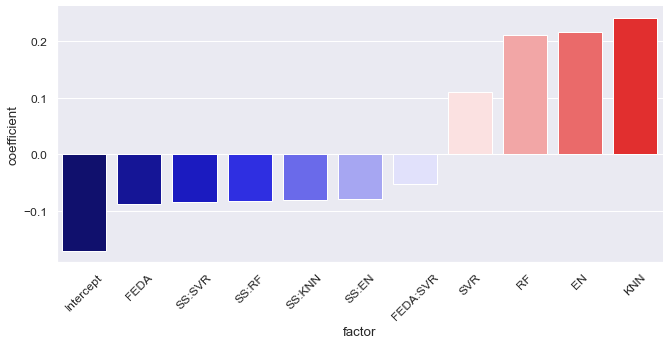

In [74]:
sns.set(font_scale=1.1)
g = sns.catplot(x='factor', y='coef', data=anova[(anova['coef']>0.05)|(anova['coef']<-0.05)],height=5, kind='bar', palette=sns.color_palette("seismic", n_colors=14)[:-3], aspect=1.9)
labels = ['Intercept', 'FEDA','SS:SVR', 'SS:RF','SS:KNN','SS:EN', 'FEDA:SVR', 
          'SVR', 'RF', 'EN', 'KNN']
g.set_xticklabels(labels,rotation=45)
g.set(ylabel='coefficient')
plt.tight_layout()
#plt.savefig('graphs/anova.eps', format='eps')

# Statistical analysis

Here we calculate the p values and store them in an excel file. These will be used to determine if certain characteristics outperform others. Having statistically significant differences in their means

In [116]:
import scikit_posthocs as sp

In [117]:
data = {}

In [118]:
data['datasets'] = sp.posthoc_ttest(clean, val_col='r2', group_col='datasets', equal_var=False)

In [119]:
data['datime'] = sp.posthoc_ttest(clean, val_col='seconds', group_col='da',p_adjust='bonferroni', equal_var=False)

In [120]:
data['dar2'] = sp.posthoc_ttest(clean, val_col='r2', group_col='da',p_adjust='bonferroni', equal_var=False)

In [121]:
data['drug_metric']= sp.posthoc_ttest(clean, val_col='r2', group_col='metric_drug',p_adjust='bonferroni', equal_var=False)

In [122]:
data['ajive'] = sp.posthoc_ttest(clean[clean['ajive'].notnull()], val_col='r2', group_col='ajive',p_adjust='bonferroni', equal_var=False)

In [124]:
data['model']= sp.posthoc_ttest(clean, val_col='r2', group_col='model',p_adjust='bonferroni', equal_var=False)

In [126]:
data['norm']=sp.posthoc_ttest(clean, val_col='r2', group_col='norm', equal_var=False).sort_index()

In [127]:
clean['catnmodel'] = clean['model']+clean['catn'].astype(str)
data['catnmodel'] = sp.posthoc_ttest(clean, val_col='r2', group_col='catnmodel', equal_var=False).sort_index()

In [128]:
clean['damodel'] = clean['da']+clean['model']
data['damodel'] = sp.posthoc_ttest(clean, val_col='r2', group_col='damodel', equal_var=False)

In [129]:
clean['normodel'] = clean['model']+clean['norm']
data['normodel'] = sp.posthoc_ttest(clean, val_col='r2', group_col='normodel',p_adjust='bonferroni', equal_var=False).sort_index()

In [130]:
data['norm'] = sp.posthoc_ttest(clean, val_col='r2', group_col='norm',p_adjust='bonferroni', equal_var=False).sort_index()

In [132]:
clean['fsmodel'] = clean['model']+clean['fs']
data['fsmodel'] = sp.posthoc_ttest(clean, val_col='r2', group_col='fsmodel', equal_var=False).sort_index()

In [187]:
with pd.ExcelWriter('pvalues.xlsx') as writer:
    for k,v in data.items():
        v.to_excel(writer, sheet_name=k)

# Odds Ratio

In [94]:
def OR(indices, rest, top, group):
    li = []
    for i in indices:
        model_t = top[(top[group[0]]==i[0])&(top[group[1]]==i[1])].shape[0]
        nmodel_t = top[(top[group[0]]!=i[0])|(top[group[1]]!=i[1])].shape[0]
        model_r = rest[(rest[group[0]]==i[0])&(rest[group[1]]==i[1])].shape[0]
        nmodel_r = rest[(rest[group[0]]!=i[0])|(rest[group[1]]!=i[1])].shape[0]
        if model_r > 0 and nmodel_r > 0:
            li.append((model_t/model_r)/(nmodel_t/nmodel_r))
        else:
            li.append(0)
    return li

In [95]:
def top_OR(data, group, q=0.95, score='r2_score'):
    top = data[data[score] >= data[score].quantile(q)]
    counts = data[group +[score]].groupby(group).count()
    topcounts = top[group +[score]].groupby(group).count()
    topcounts['OR'] = OR(topcounts.index, data[data[score]<data[score].quantile(q)], top, group)
    return topcounts

In [96]:
def ORone(indices, rest, top, group):
    li = []
    for i in indices:
        model_t = top[(top[group[0]]==i)].shape[0]
        nmodel_t = top[(top[group[0]]!=i)].shape[0]
        model_r = rest[(rest[group[0]]==i)].shape[0]
        nmodel_r = rest[(rest[group[0]]!=i)].shape[0]
        if model_r > 0 and nmodel_r > 0:
            li.append((model_t/model_r)/(nmodel_t/nmodel_r))
        else:
            li.append(0)
    return li

In [97]:
def one_OR(data, group, q=0.95, score='r2_score'):
    top = data[data[score] >= data[score].quantile(q)]
    counts = data[group +[score]].groupby(group).count()
    topcounts = top[group +[score]].groupby(group).count()
    topcounts['OR'] = ORone(topcounts.index, data[data[score]<data[score].quantile(q)], top, group)
    return topcounts

# Hyper parameters

Here some initial exploration of the hyper parameters of the models is performed 

## KNN

In [82]:
knn = clean[clean['model']=='KNeighborsRegressor'][['Drug', 'fs', 'da','ajive', 'catn', 'n_neighbors', 'weights', 'algorithm', 'p','r2_score', 'r2']]

In [83]:
knn.head()

,Drug,fs,da,ajive,catn,n_neighbors,weights,algorithm,p,r2_score,r2
207,AZD6482,Lasso,none,NaN,low,29.0,uniform,ball_tree,1.0,0.416520,0.236597
208,AZD7762,Lasso,none,NaN,low,13.0,distance,ball_tree,1.0,0.377099,0.109259
209,BMS-754807,Lasso,none,NaN,low,20.0,distance,ball_tree,2.0,0.112876,0.033824
210,Dasatinib,Lasso,none,NaN,low,14.0,distance,ball_tree,1.0,0.427305,0.157184
211,Docetaxel,Lasso,none,NaN,low,24.0,distance,kd_tree,1.0,0.107432,-0.010444


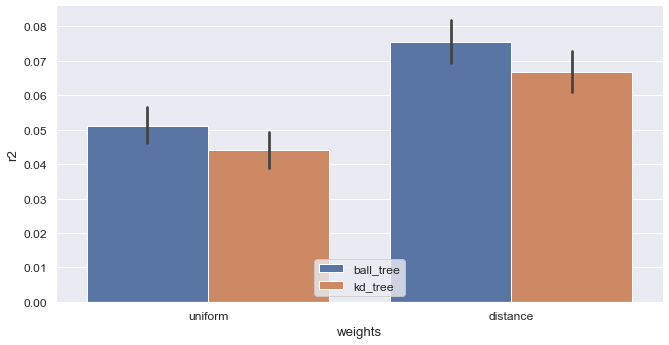

In [84]:
sns.set(font_scale=1.1)
#order= ['DecisionTreeRegressor', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'SVR']
g = sns.catplot(x='weights', y='r2', hue='algorithm', data=knn[knn['n_neighbors']>5], kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

plt.legend(loc='lower center')
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-n.eps', format='eps')

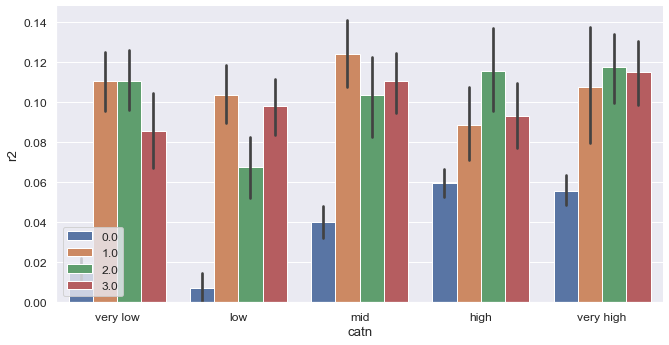

In [86]:
knn['ajive'] = knn['ajive'].fillna(0)
sns.set(font_scale=1.1)
order= ['very low', 'low', 'mid', 'high', 'very high']

g = sns.catplot(x='catn', y='r2',order=order, hue='ajive', data=knn, kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

plt.legend(loc='lower left')
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-n.eps', format='eps')

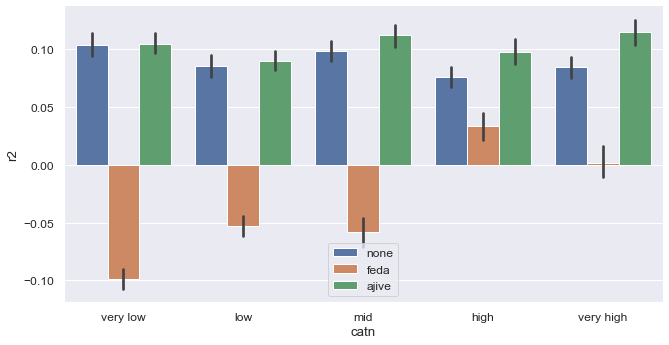

In [87]:
sns.set(font_scale=1.1)
order= ['very low', 'low', 'mid', 'high', 'very high']
g = sns.catplot(x='catn', y='r2',hue='da', data=knn,order=order, kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

plt.legend(loc='lower center')
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-n.eps', format='eps')

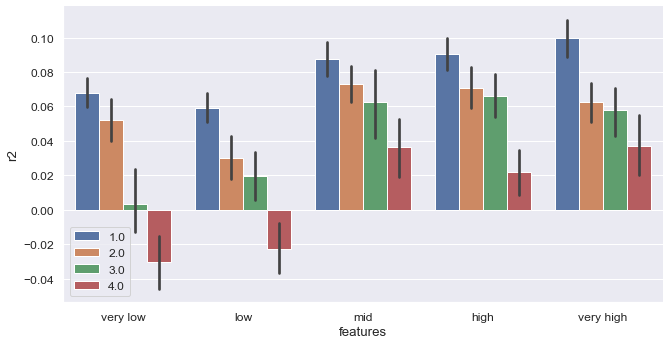

In [88]:
sns.set(font_scale=1.1)
order= ['very low', 'low', 'mid', 'high', 'very high']
g = sns.catplot(x='catn', y='r2', hue='p', data=knn,order=order, kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

plt.legend(loc='lower left')
plt.tight_layout()
g.set(xlabel='features')
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-n.eps', format='eps')

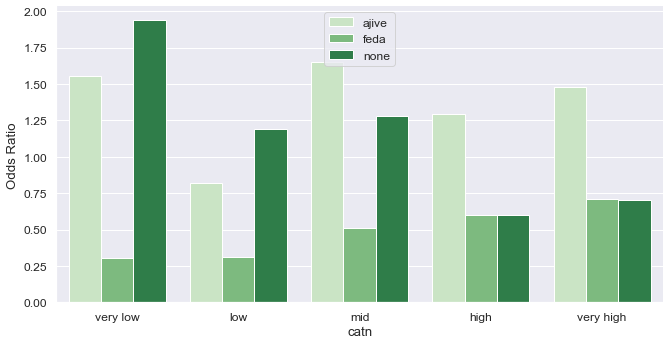

In [98]:
sns.set(font_scale=1.1)
#hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'catn', y='OR', hue='da',order=order,data=top_OR(knn, ['da', 'catn'], score='r2').reset_index(), kind='bar', palette='Greens', height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='upper center')
plt.tight_layout()
#plt.savefig('graphs/adjusted-top-n.eps', format='eps')

## Random Forest

In [99]:
rf = clean[clean['model']=='RandomForestRegressor'][['Drug', 'fs', 'da', 'catn', 'n_estimators', 'max_depth', 'max_features','r2_score', 'r2']]

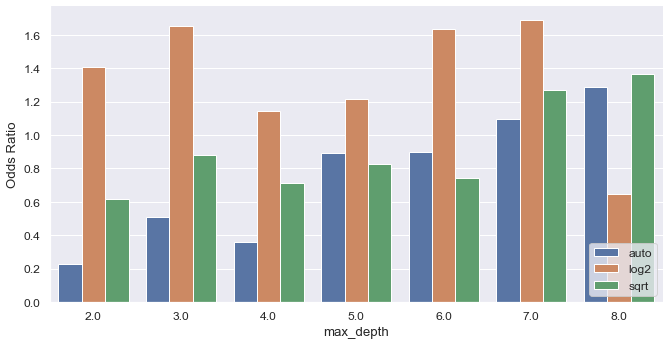

In [100]:
sns.set(font_scale=1.1)
#hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'max_depth', y='OR', hue='max_features',data=top_OR(rf, ['max_depth', 'max_features'], score='r2').reset_index(), kind='bar', height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('graphs/adjusted-top-n.eps', format='eps')

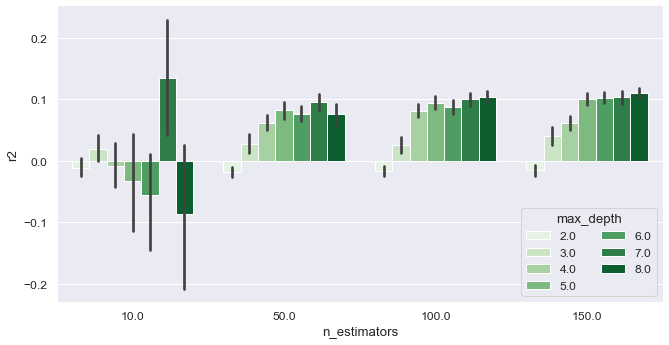

In [101]:
sns.set(font_scale=1.1)

g = sns.catplot(x='n_estimators', y='r2', hue='max_depth', data=rf, kind='bar',palette='Greens',height=5, aspect=1.9, legend=False)
#order= ['DecisionTreeRegressor', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'SVR']
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
plt.legend(title='max_depth',ncol=2)
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-depth.eps', format='eps')

No handles with labels found to put in legend.


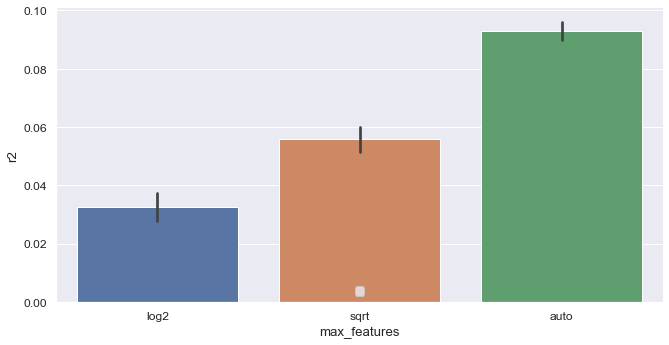

In [102]:
sns.set(font_scale=1.1)
#order= ['DecisionTreeRegressor', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'SVR']
g = sns.catplot(x='max_features', y='r2', data=rf, kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

plt.legend(loc='lower center')
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-depth.eps', format='eps')

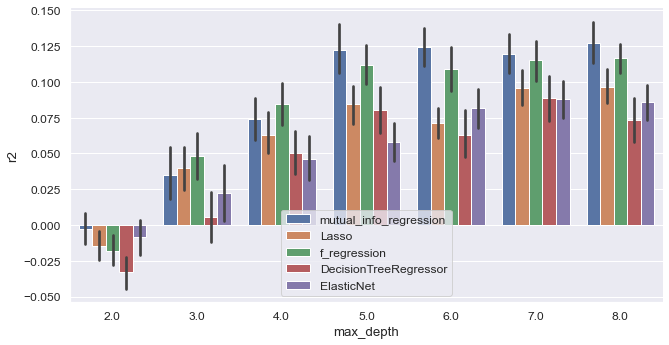

In [103]:
sns.set(font_scale=1.1)
#order= ['DecisionTreeRegressor', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'SVR']
g = sns.catplot(x='max_depth', y='r2', hue='fs', data=rf, kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

plt.legend(loc='lower center')
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-n.eps', format='eps')

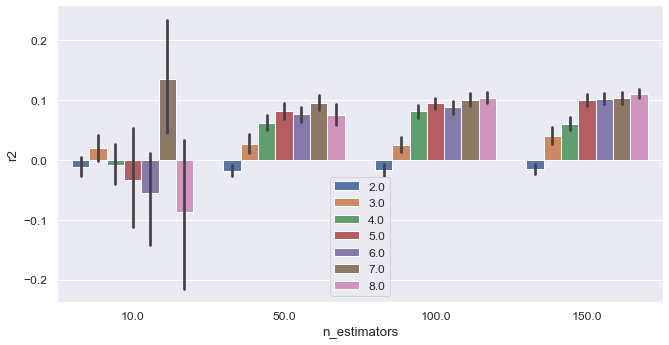

In [104]:
sns.set(font_scale=1.1)
#order= ['DecisionTreeRegressor', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'SVR']
g = sns.catplot(x='n_estimators', y='r2', hue='max_depth', data=rf, kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

plt.legend(loc='lower center')
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-n.eps', format='eps')

## Elastic Net

In [105]:
en = clean[clean['model']=='ElasticNet'][['Drug', 'fs', 'da', 'catn', 'alpha', 'l1_ratio','r2_score', 'r2']]

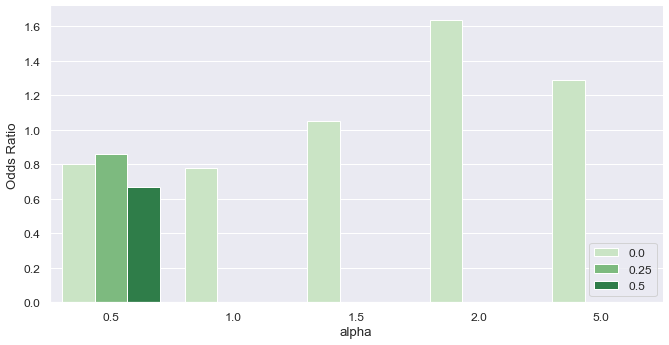

In [106]:
sns.set(font_scale=1.1)
#hue = ['DecisionTreeRegressor', 'mutual_info_regression', 'ElasticNet', 'f_regression', 'Lasso', 'RandomForestRegressor', ]
g = sns.catplot(x = 'alpha', y='OR', hue='l1_ratio',data=top_OR(en, ['l1_ratio', 'alpha'], score='r2').reset_index(), kind='bar', palette='Greens', height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])
g.set_ylabels('Odds Ratio')
plt.legend(loc='lower right')
plt.tight_layout()
#plt.savefig('graphs/adjusted-top-n.eps', format='eps')

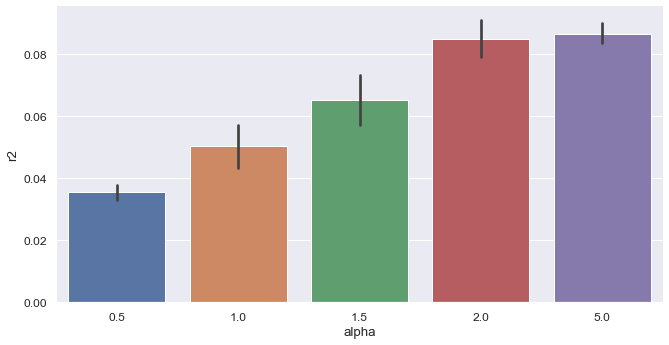

In [107]:
sns.set(font_scale=1.1)
#order= ['DecisionTreeRegressor', 'ElasticNet', 'KNeighborsRegressor', 'RandomForestRegressor', 'SVR']
g = sns.catplot(x='alpha', y='r2', data=en, kind='bar',height=5, aspect=1.9, legend=False)
#g.set_xticklabels(['Decision Tree', 'Elastic Net', 'KNN', 'Random Forest', 'SVR'])

#plt.legend(loc='lower center')
plt.tight_layout()
#g.set(yscale='symlog')
#plt.savefig('graphs/adjusted-n.eps', format='eps')